In [48]:
'''We start with the packages that we will need in our procedure'''

%pylab inline

import pymc3 as pm
from pymc3.backends import SQLite
import triangle
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/enriques/Downloads/yes/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['size', 'trace', 'step', 'figsize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [49]:
# Initialize random number generator
np.random.seed(123)

#True parameter values
a1_real = 0.7
b1_real = 0.7
sigma1 = 0.02

a2_real = 1.
b2_real = 1.
sigma2 = 0.1

size = 5
#Generating our data

def stright(a,b,size,sigma):
    x = np.random.randn(size)
    y = a+b*x+np.random.randn(size)*sigma
    return x, y

x1, y1 = stright(a1_real,b1_real,size,sigma1)
x2, y2 = stright(a2_real,b2_real,size,sigma2)

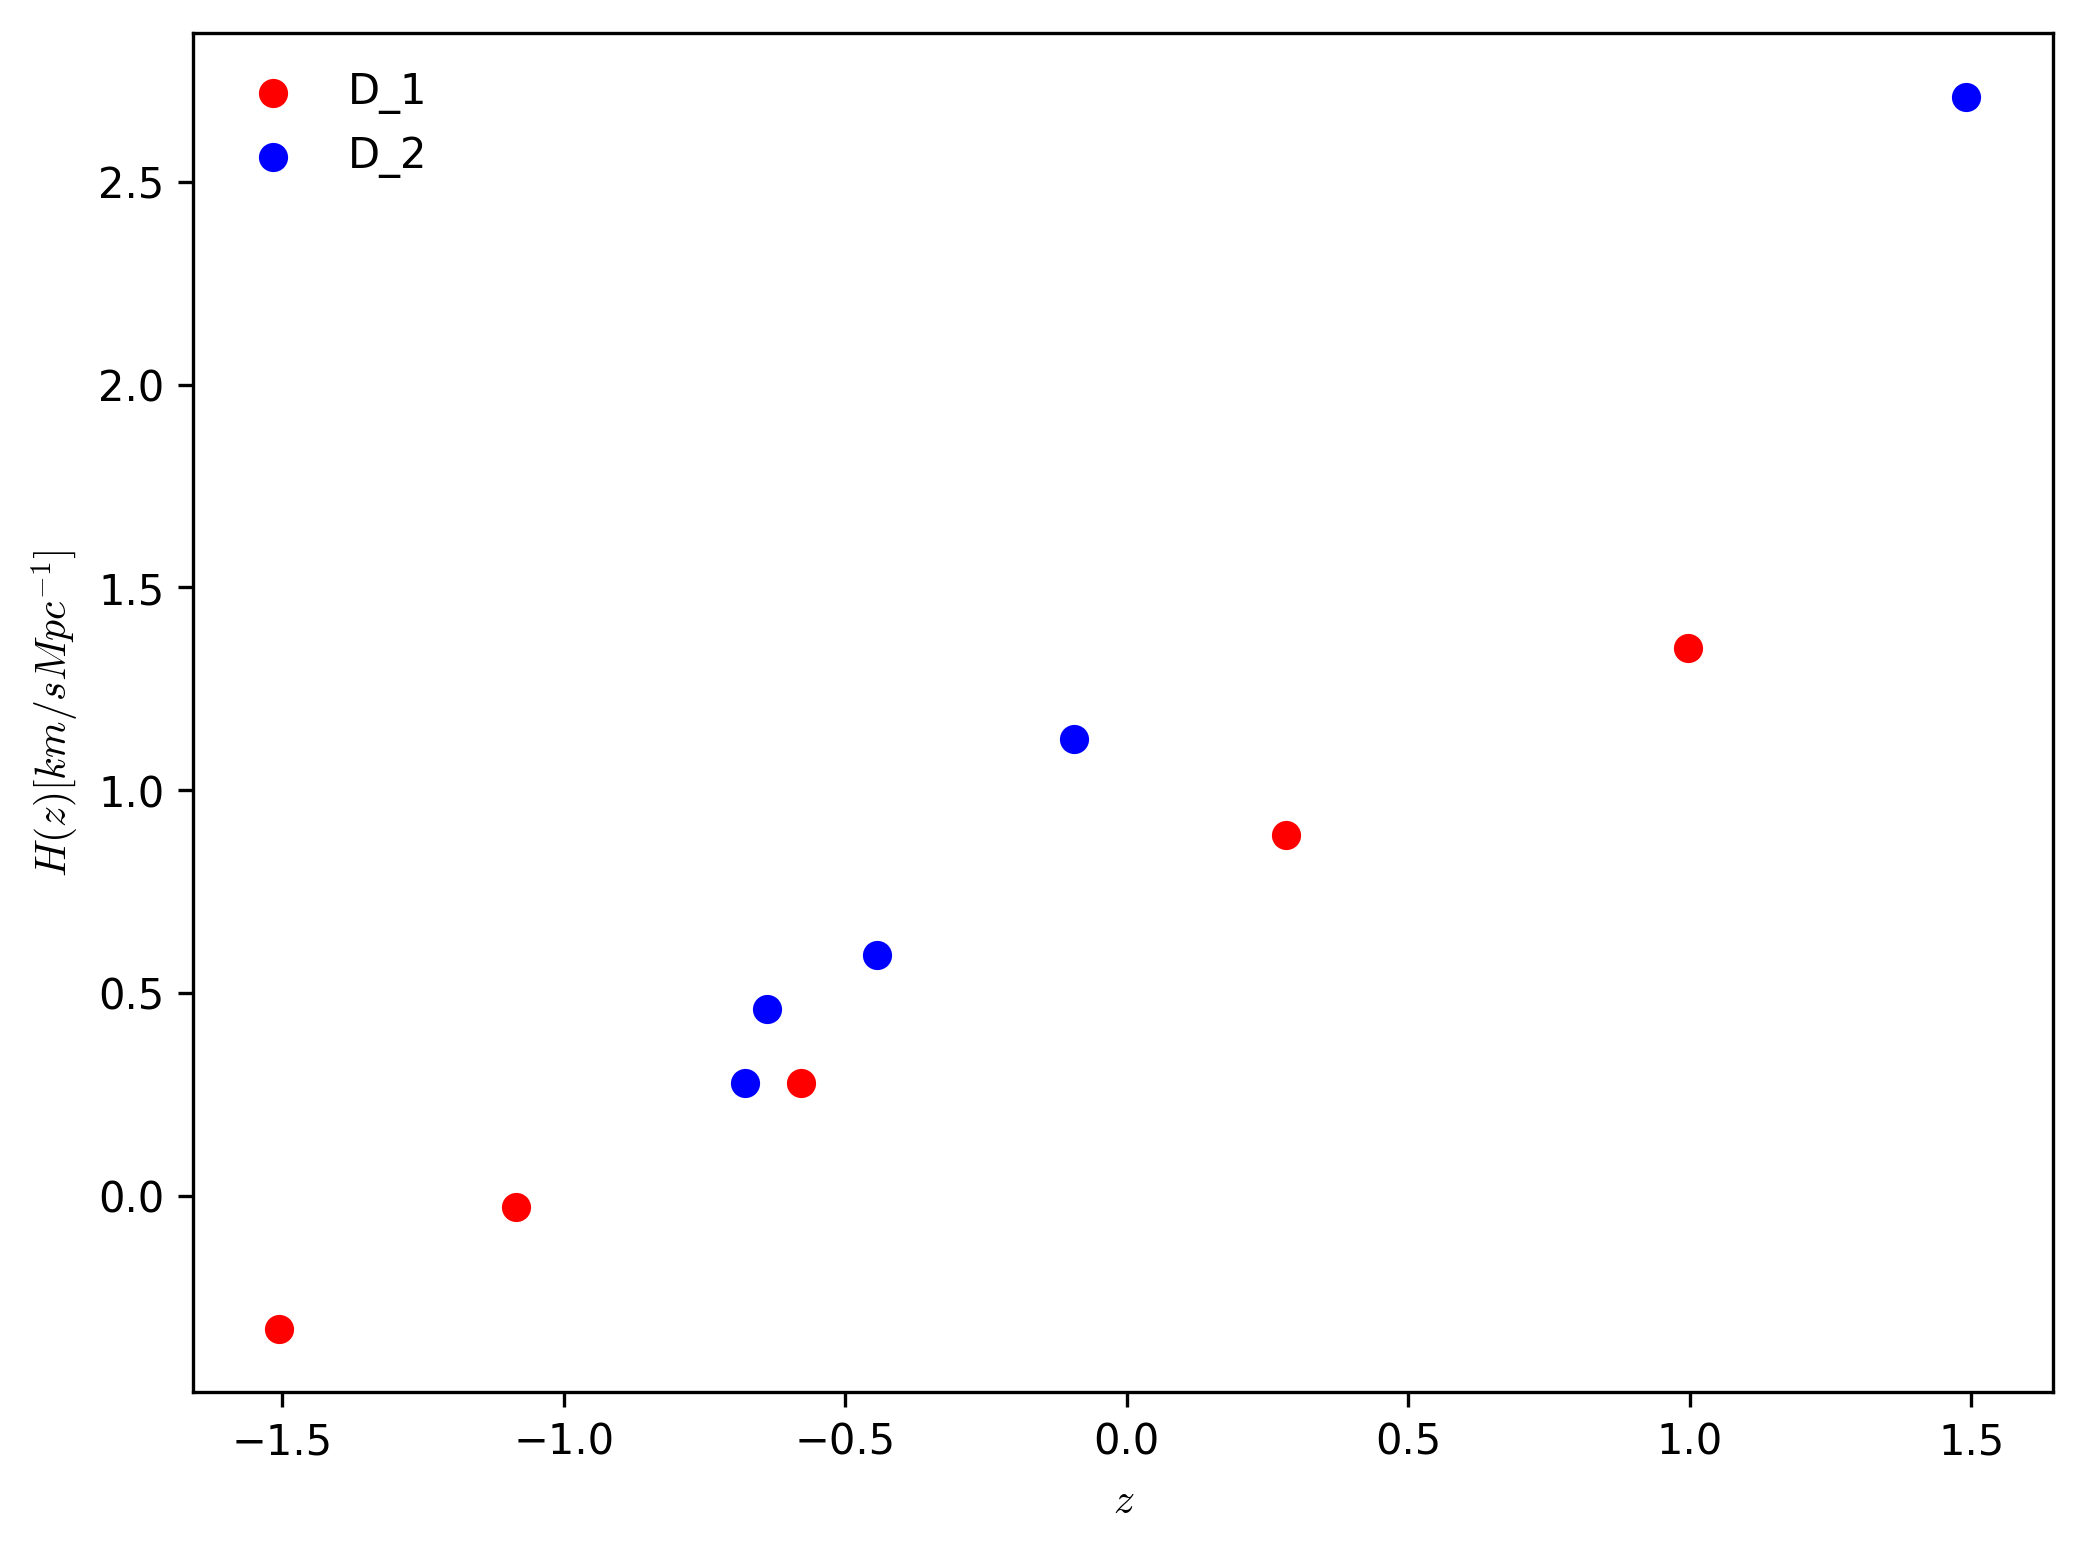

In [50]:
figsize = (8, 6)                        # definimos el tamaño de nuestra figura
dpi = 300                                # dots per inch

rcParams['font.size'] = 10            # establecemos el tamaño de la fuente
rcParams['lines.linewidth'] = 1          # el grosor de las líneas
rcParams['mathtext.fontset'] = 'cm'      # y el tipo de fuente en LaTex 

fig1 = figure(figsize=figsize, dpi=dpi)  # definimos la figura

 
plt.scatter(x1,y1,color="red",label = "D_1")
plt.scatter(x2,y2,color="blue",label = "D_2")

plt.legend(loc='best', frameon=False)     #pon la legenda donde mejor quede sin marco

xlabel(r'$z$')                            
ylabel(r'$H(z) [km/s Mpc^{-1}]$')

In [51]:
Data_x = np.concatenate((x1,x2),axis = 0)
Data_y = np.concatenate((y1,y2),axis = 0)

with pm.Model() as model0:
    # Priors for unknown model parameters
    a0 = pm.Uniform('a0', lower=-5, upper=5)
    b0 = pm.Uniform('b0', lower=0, upper=4)
    sigma0 = pm.Uniform('sigma0', lower = 0, upper = 3)
    
    y0 = a0+b0*Data_x
    
    Lik0 = pm.Normal('Lik0',mu=y0,sd=sigma0,observed=Data_y) 

In [54]:
#We specify the number of iterations
niter0=10000
with model0:
    start0 = pm.find_MAP() #Compute a maximum a posteriori estimates 
    step0 = pm.Metropolis()
    db0 = SQLite('H0mod_2_Data.db')
    trace0 = pm.sample(niter0, trace=db0, step=step0, start=start0, njobs=6, temp = 2, thin=20, cores=4,random_seed=123)

logp = -5.1487, ||grad|| = 0.017582: 100%|██████████| 25/25 [00:00<00:00, 2328.82it/s]  
Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [sigma0_interval__]
>Metropolis: [b0_interval__]
>Metropolis: [a0_interval__]
  0%|          | 0/10500 [00:00<?, ?it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 36%|███▌      | 3799/10500 [00:03<00:06, 975.98it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 66%|██████▌   | 6944/10500 [00:

In [7]:
start0

{'a0': array(0.93366873),
 'a0_interval__': array(0.37790151),
 'b0': array(0.8895335),
 'b0_interval__': array(-1.25183082),
 'sigma0': array(0.2508705),
 'sigma0_interval__': array(-2.39410272)}

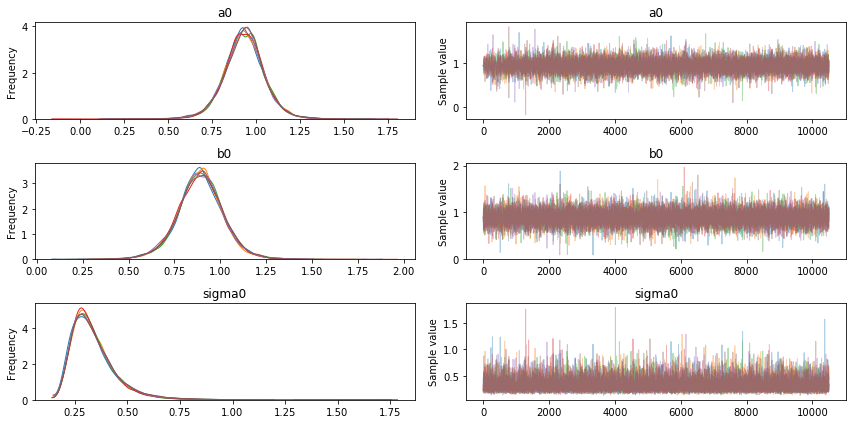

In [8]:
with model0:
    tracee = pm.backends.sqlite.load('H0mod_2_Data.db')
    pm.traceplot(tracee, varnames=['a0','b0','sigma0'])

In [9]:
t0 = trace0[niter0//2:]
t0['a0'].shape
t0['b0'].shape
t0['sigma0'].shape

(30000,)

In [10]:
a0 = trace0.get_values('a0', burn=niter0//2, combine=True, chains=[0,2])
a0.shape

b0 = trace0.get_values('b0', burn=niter0//2, combine=True, chains=[0,2])
b0.shape

sigma0 = trace0.get_values('sigma0', burn=niter0//2, combine=True, chains=[0,2])
sigma0.shape

(10000,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xef16e10>,
      dtype=object)

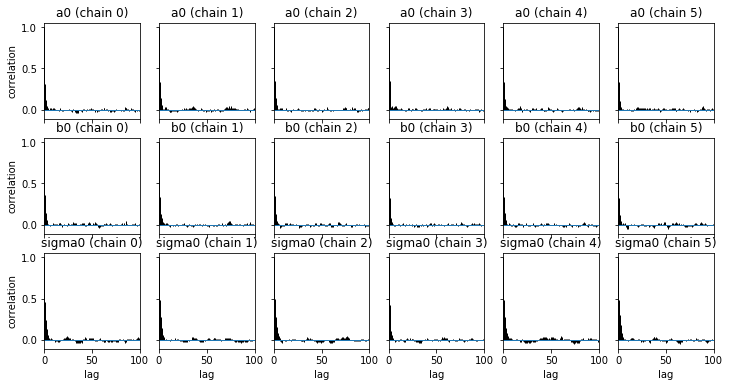

In [11]:
pm.autocorrplot(t0, varnames=['a0','b0','sigma0'])

In [12]:
pm.effective_n(t0)

{'a0': 13549.0, 'b0': 14180.0, 'sigma0': 9926.0}

In [13]:
pm.gelman_rubin(t0)

{'a0': 1.0000744680406877,
 'b0': 0.9999869383988187,
 'sigma0': 1.0006157438765324}

In [14]:
pm.summary(t0, varnames=['a0','b0','sigma0'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a0,0.933320,0.114562,0.001066,0.707174,1.165852,13549.0,1.000074
b0,0.889367,0.127118,0.001033,0.631555,1.137305,14180.0,0.999987
sigma0,0.336630,0.106752,0.001076,0.171889,0.539282,9926.0,1.000616


/home/enriques/Downloads/yes/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/home/enriques/Downloads/yes/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  from ipykernel import kernelapp as app


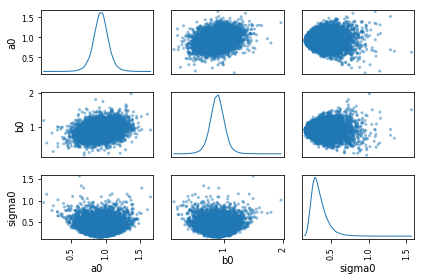

In [15]:
df_trace0 = pm.trace_to_dataframe(trace0[niter0//2:])
pd.scatter_matrix(df_trace0.ix[-niter0//2:, ['a0', 'b0','sigma0']], diagonal='kde')
plt.tight_layout()
plt.show()

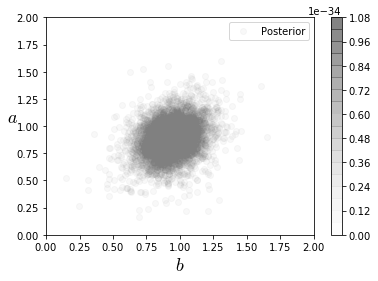

In [34]:
plot(a0, b0,
     linestyle='none', marker='o', color='grey', mec='grey',
alpha=.05, label='Posterior', zorder=-100)

import scipy.stats
gkde = scipy.stats.gaussian_kde([a0, b0])
x,y = mgrid[0.:1.:5., 0.:100.:4.]
z = array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
contourf(x, y, z,20, linewidths=1, alpha=.5, cmap='Greys')
plt.colorbar();

ylabel(r'$a$', fontsize=18, rotation=0)
xlabel(r'$b$', fontsize=18)
legend()
axis([0., 2., 0., 2.])
savefig('param_dist.png')

In [17]:
import theano.tensor as T
import theano as TT

def ymodel(a,b,x):
    return a+b*x
    
def chi2(a,b,x,data,sigma2,n):
    D = ymodel(a,b,x)-data
    sigma2_mat_inv = T.nlinalg.AllocDiag()((1/sigma2)*T.ones(n))
    return T.dot(D,T.dot(sigma2_mat_inv,D))/2

def log_Like1D(a,b,x,y,sigma2,n):
    N = 1*n/2+1.
    extr = 2/(math.pi**(n/2)*sigma2**(size/2))
    return T.gammaln(N)-N*T.log(chi2(a,b,x,y,sigma2,n)+2)+T.log(extr)

with pm.Model() as model1:
    # Priors for unknown model parameters
    a = pm.Uniform('a', lower=-5., upper=8.)
    b = pm.Uniform('b', lower=0., upper=4.)
    sigma2 = pm.Uniform('sigma', lower = 0., upper = 1.)
   
    Lik = pm.Potential('Lik',log_Like1D(a,b,x1,y1,sigma2,size)+log_Like1D(a,b,x2,y2,sigma2,size))

In [18]:
niter=10000
with model1:
    start = pm.find_MAP() #Compute a maximum a posteriori estimates 
    step = pm.Metropolis()
    db = SQLite('MH1mod_2Data.db')
    trace = pm.sample(niter, trace=db, step=step, start=start,njobs=5,temp = 2,thin=20,cores = 4, random_seed=123)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
logp = -5.1643, ||grad|| = 56.778: 100%|██████████| 31/31 [00:00<00:00, 663.57it/s]  
Multiprocess sampling (5 chains in 5 jobs)
CompoundStep
>Metropolis: [sigma_interval__]
>Metropolis: [b_interval__]
>Metropolis: [a_interval__]
  0%|          | 0/10500 [00:00<?, ?it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 28%|██▊       | 2964/10500 [00:05<00:12, 585.88it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedint

In [19]:
start

{'a': array(1.09002348),
 'a_interval__': array(-0.1263143),
 'b': array(1.05877985),
 'b_interval__': array(-1.02170736),
 'sigma': array(0.01278868),
 'sigma_interval__': array(-4.3463234)}

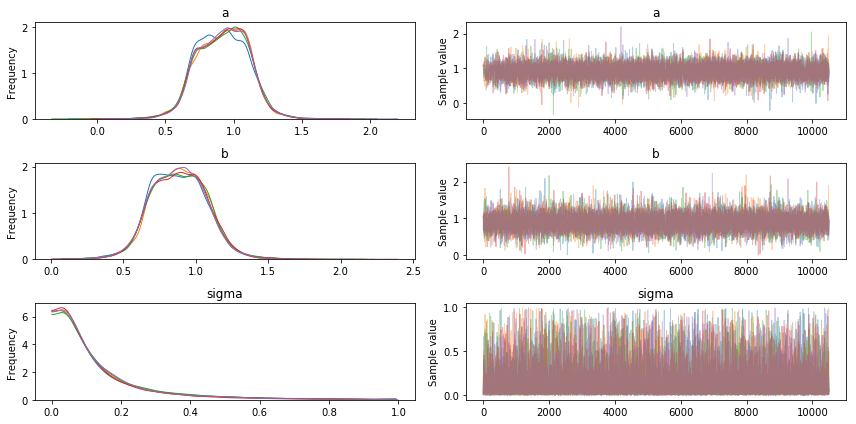

In [20]:
with model1:
    tracee = pm.backends.sqlite.load('MH1straight_2Data.db')
    pm.traceplot(tracee, varnames=['a','b','sigma'])

In [21]:
t = trace[niter//2:]
t['a'].shape
t['b'].shape
t['sigma'].shape

(25000,)

In [22]:
a = trace.get_values('a', burn=niter//2, combine=True, chains=[0,2])
a.shape

b = trace.get_values('b', burn=niter//2, combine=True, chains=[0,2])
b.shape

sigma = trace.get_values('sigma', burn=niter//2, combine=True, chains=[0,2])
sigma.shape

(10000,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xb9f4f90>,
      dtype=object)

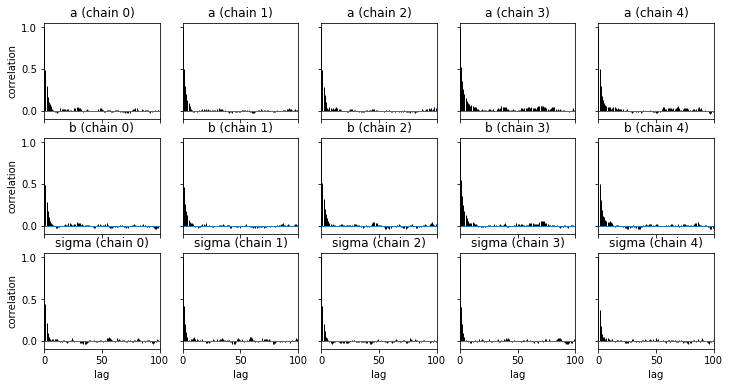

In [23]:
pm.autocorrplot(t, varnames=['a','b','sigma'])

In [24]:
pm.effective_n(t)

{'a': 5488.0, 'b': 6521.0, 'sigma': 9253.0}

In [25]:
pm.gelman_rubin(t)

{'a': 1.0001667753600865, 'b': 1.0000203930468143, 'sigma': 1.0007012178991428}

In [26]:
pm.summary(t, varnames=['a','b','sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.923107,0.184502,0.002431,0.580832,1.261919,5488.0,1.000167
b,0.886853,0.194134,0.002131,0.504882,1.237882,6521.0,1.000020
sigma,0.134000,0.149305,0.001510,0.000243,0.456030,9253.0,1.000701


/home/enriques/Downloads/yes/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/home/enriques/Downloads/yes/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  from ipykernel import kernelapp as app


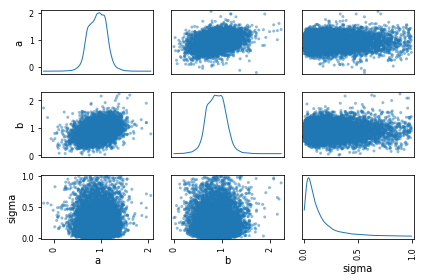

In [27]:
df_trace = pm.trace_to_dataframe(tracee[niter//2:])
pd.scatter_matrix(df_trace.ix[-niter//2:, ['a', 'b','sigma']], diagonal='kde')
plt.tight_layout()
plt.show()

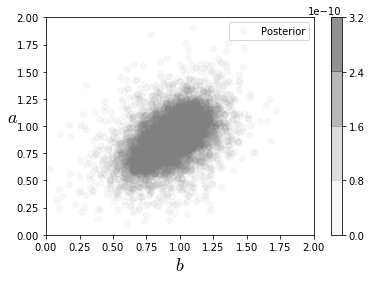

In [28]:
plot(a, b,
     linestyle='none', marker='o', color='grey', mec='grey',
alpha=.05, label='Posterior', zorder=-100)

import scipy.stats
gkde = scipy.stats.gaussian_kde([a, b])
x,y = mgrid[0.:1.:5., 0.:100.:4.]
z = array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
contourf(x, y, z,4, linewidths=1, alpha=.5, cmap='Greys')
plt.colorbar();

ylabel(r'$a$', fontsize=18, rotation=0)
xlabel(r'$b$', fontsize=18)
legend()
axis([0., 2., 0., 2.])
savefig('param_dist.png')

# But, what method is better?

##### PyMC contains a way to estimate the Bayes factor using the Sequential Monte Carlo method. So, let us recalculate our posterior using this method

In [72]:
#We specify the number of iterations
from tempfile import mkdtemp
from pymc3.step_methods import smc 
niter0=25000
folder = mkdtemp(prefix='strightline')
with model0:
    trace0_nm = smc.sample_smc(niter0,n_chains = 10,homepath = folder,progressbar=False,stage = 0,random_seed=123)
    
with model1:
    trace1_nm = smc.sample_smc(niter0,n_chains = 10,homepath = folder,progressbar=False,stage = 0,random_seed=123)

Argument `step` is None. Auto-initialising step object using given/default parameters.
Using present model likelihood!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
Beta: 0.115468 Stage: 1
Initialising chain traces ...
Sampling ...
Beta: 0.205785 Stage: 2
Initialising chain traces ...
Sampling ...
Beta: 0.339332 Stage: 3
Initialising chain traces ...
Sampling ...
Beta: 0.539987 Stage: 4
Initialising chain traces ...
Sampling ...
Beta > 1.: 1.378754
Sample final stage
Initialising chain traces ...
Sampling ...
Argument `step` is None. Auto-initialising step object using given/default parameters.
Using present model likelihood!
Removing previous sampling results ... /tmp/strightlineZRQU4e/stage_0
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
Beta: 0.212535 Stage: 1
Removing previous sampling results ... /tmp/strightlineZRQU4e/stage_1
Initialising chain traces ...


In [73]:
#Computing the Bayes factor
BF = model1.marginal_likelihood / model0.marginal_likelihood
print(round(BF))

4.0
